## Train

- Input:
    - Numerical data with important features
    - Engineered time features
- Output:
    - submission
- Model:
    - XGBoost
    
Time features:
1. Together with test data
    1. ID difference to the previous and next row when sorted by date_start and ID, Time_analysis.ipynb.
    2. ID difference to the previous and next row when sorted by date_end and ID, Time_analysis.ipynb.
    3. ID difference to the previous and next row when sorted by line start time and ID, Time_analysis.ipynb.
    
2. Independent of test data
    4. Duration of whole production binned by 8 or 12 hours, e.g., Time_analysis.ipynb.
    5. The binned day of a week, hour of a week, and hour of a day for date_start and date_end, e.g., Time_analysis.ipynb
    6. Binned date_start, date_end, and duration on each station and line, e.g., station_time.ipynb and line_time.ipynb. 
        - **The bin edges should be saved for test data.**
    7. Station flows converted to a number. 
        - **This is actually a categorical feature, should make XGBoost tree deep.**
    8. Segments of production duration
    
3. Out of fold features
    9. Row distance to the previous error when sorted by ID
    10. Row distance to the previous error when sorted by date_start and ID
    11. Row distance to the previous error when sorted by date_end and ID
    12. The bayesian mean of (E) 
    13. The bayesian mean of (F) 
    14. The bayesian mean of (G)
    

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sys import getsizeof
import time
import gc
import tqdm

%matplotlib inline

C:\Users\home\Anaconda3\envs\kaggle\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import pickle

def save_pickle(x, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(x, handle, protocol=pickle.HIGHEST_PROTOCOL)

def read_pickle(filename):
    with open(filename, 'rb') as handle:
        x = pickle.load(handle)
    return x

### Load date data

In [3]:
# columns in date data
col_types = pd.read_csv('data/train_date.csv.zip', nrows=1)
col_types = pd.read_csv('data/train_date.csv.zip', nrows=1)
col_types = {k: np.float16 for k in col_types.columns}
col_types['Id'] = np.int64

# Load date data
x_train_date = pd.read_csv('data/train_date.csv.zip', index_col=0, dtype=col_types, engine='c')
x_test_date = pd.read_csv('data/test_date.csv.zip', index_col=0, dtype=col_types, engine='c')
print('Memory usage of x_train_date is {:.3f}G.'.format(x_train_date.memory_usage(deep=True).sum()*10**-9))
print('Memory usage of x_test_date is {:.3f}G.'.format(x_test_date.memory_usage(deep=True).sum()*10**-9))

C:\Users\home\Anaconda3\envs\kaggle\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Memory usage of x_train_date is 2.746G.
Memory usage of x_test_date is 2.746G.


In [4]:
n_train = x_train_date.shape[0]
x_all_date = pd.concat([x_train_date, x_test_date])
#del x_train_date, x_test_date
#gc.collect()

x_all_date.reset_index(inplace=True)
x_all_date.reset_index(inplace=True)
x_all_date.set_index('Id', drop=False, inplace=True)
x_all_date.rename(columns={'index':'idx'}, inplace=True)
x_all_date.head()

,idx,Id,L0_S0_D1,L0_S0_D3,L0_S0_D5,L0_S0_D7,L0_S0_D9,L0_S0_D11,L0_S0_D13,L0_S0_D15,...,L3_S50_D4246,L3_S50_D4248,L3_S50_D4250,L3_S50_D4252,L3_S50_D4254,L3_S51_D4255,L3_S51_D4257,L3_S51_D4259,L3_S51_D4261,L3_S51_D4263
Id,,,,,,,,,,,,,,,,,,,,,
4,0,4,82.25,82.25,82.25,82.25,82.25,82.25,82.25,82.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2,7,1619.00,1619.00,1619.00,1619.00,1619.00,1619.00,1619.00,1619.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3,9,1149.00,1149.00,1149.00,1149.00,1149.00,1149.00,1149.00,1149.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,4,11,602.50,602.50,602.50,602.50,602.50,602.50,602.50,602.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Time features

Together with test data

- Start/end times when part flows through a station, continuous and binned.
- Start/end times when part flows through a line, continuous and binned.
- ID difference when rows are sorted by certain creteria
    - Start/end times flowing through station, line, or overall-start/end times
    - ID
- Modulo time in a period
    - 2.5h, 24h, or 168h
- Number of samples in the same time (6 mins)

    



In [5]:
def calculate_station_time(df, bin_edges=None):
    '''
    Calculate start time, end time, and duration for parts on each station
    
    Output:
    station_time: the start, end, and duration time on each station
    station_time_binned: the binned data
    station_time_bins: contains bin edges to transform new data
    '''
    
    columns = [f for f in df.columns.tolist() if f not in ['Response', 'Id', 'idx'] ]
    # list of station names
    stations = list(set([f.split('_')[1] for f in columns]))
    # features in each station
    station_features = {s: [f for f in columns if s in f] for s in stations }
    
    # samples in each feature
    feature_samples = {}
    print('Calculating feature samples:')
    for col in tqdm.tqdm_notebook(columns):
        feature_samples[col] = len(df.loc[df[col].notna(), col])    
    feature_samples = pd.Series(feature_samples)
    feature_samples.sort_values(ascending=False, inplace=True)
    feature_samples = feature_samples.reset_index()
    feature_samples.columns = ['feature', 'count']
    feature_samples['station'] = feature_samples['feature'].apply(lambda x: x.split('_')[1])
    
    # samples per station
    station_samples = feature_samples.groupby('station')['count'].max().sort_values(ascending=False)
    
    # start and end times and durations for each part on each station
    station_time = {}
    print('Calculate station times:')
    for s in tqdm.tqdm_notebook(stations):
        station_time[s+'_start'] = df[station_features[s]].min(axis=1)
        station_time[s+'_end'] = df[station_features[s]].max(axis=1)
        station_time[s+'_duration'] = station_time[s+'_end'] - station_time[s+'_start']
    
    # Read the useful columns, discard the rest
    station_columns = read_pickle('station_time_columns.pickle')
    station_time2 = {}
    for k in station_columns:
        station_time2[k] = station_time[k]
    station_time = station_time2
    del station_time2
    station_time = pd.DataFrame(station_time)
    
    # stores bin edges and labels for the categorical version of station_time
    station_time_bins = {}
    station_time_binned = {}
    print('Calculate binned station times:')
    for f in tqdm.tqdm_notebook(station_columns):
        if not bin_edges:
            # if bins are not provided, use quantile cut
            bins = int(max(10, station_samples[f.split('_')[0]]/20000))
            station_time_binned[f+'_bin'], station_time_bins[f] = pd.qcut(station_time[f], retbins=True,
                q=bins, labels=False, duplicates='drop')
        else:
            # if bin edges are provided, use cut
            station_time_binned[f+'_bin'], station_time_bins[f] = pd.cut(station_time[f], retbins=True,
                bins=bin_edges[f], labels=False, duplicates='drop')
            
    station_time_binned = pd.DataFrame(station_time_binned)
    
    return station_time, station_time_binned, station_time_bins

# Test
#df = pd.read_csv('data/train_date.csv.zip', index_col=0, nrows=1000)
#station_time, station_time_binned, station_time_bins = calculate_station_time(df)
#df = pd.read_csv('data/test_date.csv.zip', index_col=0, nrows=1000)
#station_time, station_time_binned, station_time_bins = calculate_station_time(df, bin_edges=station_time_bins)
#station_time, station_time_binned, _ = calculate_station_time(x_all_date, bin_edges=None)

In [6]:
def calculate_line_time(df, bin_edges=None):
    '''
    Calculate start, end, and duration time for each part on each line.
    Then calculate ID difference (+/- 1) when sorted by line start and end time
    '''
    
    # features in each line
    columns = [f for f in df.columns.tolist() if f not in ['Response', 'Id', 'idx'] ]
    line_features = {k: [c for c in columns if c.split('_')[0]==k] for k in ['L0', 'L1', 'L2', 'L3']}
    
    # start and end times for each part in each line
    N = 1000 # calculate N rows each time, save RAM
    line = {} # contains results
    n_parts = df.shape[0]
    for l in line_features.keys():
        line[l+'_min'] = []
        line[l+'_max'] = []
        print('Calculating start and end times for line {}'.format(l))
        for i in tqdm.tqdm_notebook(range(n_parts//N+1)):
            tmp = df.iloc[i*N:min((i+1)*N, n_parts)].copy()
            line[l+'_min'].append(tmp[line_features[l]].min(axis=1))
            line[l+'_max'].append(tmp[line_features[l]].max(axis=1))
        line[l+'_min'] = pd.concat(line[l+'_min'])
        line[l+'_max'] = pd.concat(line[l+'_max'])
    # convert results to dataframe
    line = pd.DataFrame(line)
    
    # convert results to binned categorical data
    line_binned = {}
    line_bins = {}
    print('Calculate binned line times:')
    for f in tqdm.tqdm_notebook(line.columns):
        if not bin_edges:
            # if bin edges are not provided, use quantile cuts
            bins = int(max(10, line['L0_min'].notna().sum()/20000))
            line_binned[f+'_bin'], line_bins[f] = pd.qcut(line[f], bins, labels=False, 
                retbins=True, duplicates='drop')
        else:
            # use given bin edges
            line_binned[f+'_bin'], line_bins[f] = pd.cut(line[f], bin_edges[f], labels=False, 
                retbins=True, duplicates='drop')
        
    line_binned = pd.DataFrame(line_binned)
    
    return line, line_binned, line_bins

#line, line_binned, line_bins = calculate_line_time(x_all_date, bin_edges=None)
#line, line_binned, line_bins = calculate_line_time(x_all_date, bin_edges=line_bins)

In [7]:
def calculate_id_diff(df, feats_sort, feats_new):
    '''
    Calculate ID difference between previous and next row when sorted by some creteria.
    
    Input:
    df: a copy of the original dataframe with only relevant columns. df should have a 'Id' column
    feats_sort: columns df is sorted by
    feats_new: a list containing two names for the new features
    Output:
    df with two new columns
    '''
    df.sort_values(feats_sort, inplace=True)
    df[feats_new[0]] = df.Id.diff().fillna(9999999)
    df[feats_new[1]] = df.Id.diff(-1).fillna(9999999)
    
    return df

In [8]:
def time_modulo(df, suffix='_mod', period=16.8):
    '''
    Time of the period, e.g., week=16.8, day=2.4
    df is a copy of original dataframe, it has Id as index and only relevent columns.
    '''
    dt = df.copy()
    cols = dt.columns.tolist()
    for c in cols:
        dt[c+suffix] = dt[c] % period
    dt.drop(cols, axis=1, inplace=True)
    
    return dt

In [9]:
def calculate_count(df, feats):
    '''
    Calculate sample counts for each value of feat in df
    '''
    dt = df.copy()
    for f in feats:
        tmp = dt.groupby(f)[f].count()
        dt[f+'_count'] = dt[f].map(tmp)
    dt.drop(feats, axis=1, inplace=True)
    
    return dt

In [10]:
def calculate_count_shift(df, suffix, period=16.8, shift=1):
    '''
    Calculate the number of samples in the shifted (next or previous) period of time bin (2.5h, 24h, or 168h).
    shift=1 for next, shift=-1 for previous, shift=0 for no shift
    '''
    dt = df.copy()
    cols = dt.columns.tolist()
    for f in cols:
        tmp_count = (dt[f] / period) // 1.0
        tmp_group = tmp_count.groupby(tmp_count).count()
        tmp_group = tmp_group.shift(-shift).fillna(0)
        dt[f+suffix] = tmp_count.map(tmp_group)
    dt.drop(cols, axis=1, inplace=True)
    
    return dt

In [11]:
# Process line and station times
line, line_binned, _ = calculate_line_time(x_all_date, bin_edges=None)
station, station_binned, _ = calculate_station_time(x_all_date, bin_edges=None)

Calculating start and end times for line L0



Calculating start and end times for line L1



Calculating start and end times for line L2



Calculating start and end times for line L3



Calculate binned line times:



Calculating feature samples:



Calculate station times:



Calculate binned station times:


In [12]:
# Calculate ID differences for line times
# according to previous data analysis (line_time.ipynb), L1 and L2 are not useful here
cols = ['L0_min', 'L0_max', 'L3_min', 'L3_max'] 
line_diff_id = line[cols].copy()
line_diff_id.reset_index(inplace=True)

for c in tqdm.tqdm_notebook(cols):
    line_diff_id = calculate_id_diff(line_diff_id, [c, 'Id'], [c+'_diff1', c+'_diff2'])
line_diff_id.drop(cols, axis=1, inplace=True)
line_diff_id.set_index('Id', inplace=True)

In [13]:
# Calculate ID differences for station times
cols = station.columns.tolist()
station_diff_id = station.copy()
station_diff_id.reset_index(inplace=True)

for c in tqdm.tqdm_notebook(cols):
    station_diff_id = calculate_id_diff(station_diff_id, [c, 'Id'], [c+'_diff1', c+'_diff2'])
station_diff_id.drop(cols, axis=1, inplace=True)
station_diff_id.set_index('Id', inplace=True)

In [14]:
# ID difference when sorted by start and end of whole data set
time_diff_id = line.copy()
cols = time_diff_id.columns.tolist()

# calculate min and max times
time_diff_id['time_min'] = time_diff_id.min(axis=1)
time_diff_id['time_max'] = time_diff_id.max(axis=1)
time_diff_id.drop(cols, axis=1, inplace=True)

# add idx
idx = x_all_date['idx'].copy()
time_diff_id = time_diff_id.join(idx)
time_diff_id.sort_values('idx', inplace=True)
time_diff_id.reset_index(inplace=True)

# ID difference when sorted by time
cols = ['time_min', 'time_max']
for c in tqdm.tqdm_notebook(cols):
    time_diff_id = calculate_id_diff(time_diff_id, [c, 'Id'], [c+'_diff1', c+'_diff2'])
# ID difference when sorted by index
time_diff_id = calculate_id_diff(time_diff_id, ['idx'], ['idx_diff1', 'idx_diff2'])

# duration of total time
time_diff_id['time_duration'] = time_diff_id['time_max'] - time_diff_id['time_min']

# remove index
time_diff_id.drop('idx', axis=1, inplace=True)
# set ID as index
time_diff_id.set_index('Id', inplace=True)

In [15]:
# hour of the day/week
time_all = time_diff_id[['time_min', 'time_max']].copy()
time_in_qd = time_modulo(time_all, suffix='_mod_qd', period=0.25)
time_in_day = time_modulo(time_all, suffix='_mod_day', period=2.4)
time_in_week = time_modulo(time_all, suffix='_mod_week', period=16.8)

In [16]:
time_counts = calculate_count(time_all, ['time_min', 'time_max'])

In [17]:
time_count_shift_p1w = calculate_count_shift(time_all, '_p1w', 16.8, 1) # p1w for plus 1 week
time_count_shift_m1w = calculate_count_shift(time_all, '_m1w', 16.8, -1) # m1w for minus 1 week

time_count_shift_p1d = calculate_count_shift(time_all, '_p1d', 2.4, 1) # p1w for plus 1 day
time_count_shift_m1d = calculate_count_shift(time_all, '_m1d', 2.4, -1) # m1w for minus 1 day

time_count_shift_p1qd = calculate_count_shift(time_all, '_p1qd', 0.25, 1) # p1w for plus 1 quarter day
time_count_shift_m1qd = calculate_count_shift(time_all, '_m1qd', 0.25, -1) # m1w for minus 1 quarter day

In [18]:
time_feats = [line, line_binned, line_diff_id, 
              station, station_binned, station_diff_id, 
              time_in_day, time_in_week, time_in_qd,
              time_counts,
              time_count_shift_p1w, time_count_shift_m1w,
              time_count_shift_p1d, time_count_shift_m1d,
              time_count_shift_p1qd, time_count_shift_m1qd, idx]
x_all_date_feats = time_diff_id.join(time_feats)
x_all_date_feats['na_counts'] = x_all_date_feats.isna().sum(axis=1)

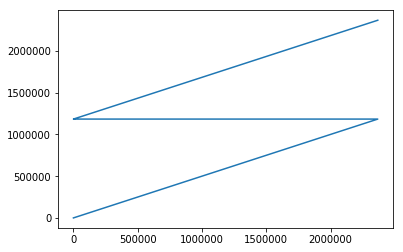

In [19]:
plt.plot(idx.index, idx.values) # this means that when sorted by idx values, the first n_train samples are train data

In [20]:
x_all_date_feats.sort_values('idx', inplace=True)
x_train_date_feats = np.float32(x_all_date_feats.iloc[:n_train].values)
x_test_date_feats = np.float32(x_all_date_feats.iloc[n_train:].values)
print('Train data: ', x_train_date_feats.shape)
print('Test data: ', x_test_date_feats.shape)

Train data:  (1183747, 311)
Test data:  (1183748, 311)


In [21]:
save_pickle(x_train_date_feats, 'x_train_date_feats_0.pickle')
save_pickle(x_test_date_feats, 'x_test_date_feats_0.pickle')

### Bayesian features

- Mean time diff to last/next 1/5/10 failures
- row distance to last/next 1/5/10 failures

In [22]:
y = pd.read_csv('data/train_numeric.csv.zip', index_col=0, usecols=[0, 969])

C:\Users\home\Anaconda3\envs\kaggle\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [125]:
x_train_time = time_all.join(idx)
#x_train_time.rename(columns={'idx': 'idx_order'}, inplace=True)
x_train_time.sort_values('idx', axis=0, inplace=True)
u = x_train_time.iloc[:n_train]
v = x_train_time.iloc[n_train:]
u.drop('idx', axis=1, inplace=True)
v.drop('idx', axis=1, inplace=True)

C:\Users\home\Anaconda3\envs\kaggle\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [126]:
u = u.join(y)

In [188]:
def bayesian_time_diff(x_train, x_test, suffix, shift, feat):
    '''
    Calculate bayesian mean time difference between neighboring failures.
    shift=n, n>0: n next failures
    shift=n, n<0: n previous failures
    x_train: has Response column
    x_test: does not have Response column, other columns should be the same as x_train
    feat: feature used for sorting and calculating distance
    '''
    assert(shift!=0), 'shift cannot equal 0!'
    
    # calculate 1st distance
    x = pd.concat([x_train, x_test]).fillna(0)
    x['idx'] = np.arange(len(x), dtype=np.int32)
    n_train = len(x_train)
    x['Response'] = x['Response'].astype(int)
    x.sort_values(feat, axis=0, inplace=True)
    
    x['res1'] = x['Response']
    x.loc[x['Response']==1, 'res1'] = x.loc[x['Response']==1, feat]
    if shift<0:
        x['res1'] = x[feat] - x['res1'].shift(1).fillna(0).replace(0, method='ffill')
    elif shift>0:
        x['res1'] = x['res1'].shift(-1).fillna(9999).replace(0, method='bfill') - x[feat]
        
    shift_abs = np.abs(shift)
    if shift_abs>1:
        for n in range(2, shift_abs+1):
            x['res'+str(n)] = x['Response']
            x.loc[x['Response']==1, 'res'+str(n)] = x.loc[x['Response']==1, 'res'+str(n-1)]
            if shift<0:
                x['res'+str(n)] = x['res'+str(n)].shift(1).fillna(0).replace(0, method='ffill') + x['res'+str(n-1)]
            elif shift>0:
                x['res'+str(n)] = x['res'+str(n)].shift(-1).fillna(9999).replace(0, method='bfill') + x['res'+str(n-1)]

    x[feat+suffix] = x[['res'+str(n) for n in range(1, shift_abs+1)]].mean(axis=1)
    x.drop(['res'+str(n) for n in range(1, shift_abs+1)], axis=1, inplace=True)
    x.sort_values('idx', axis=0, inplace=True)
    x.drop('idx', axis=1, inplace=True)
    x_train0 = x.iloc[:n_train]
    x_test0 = x.iloc[n_train:]
    x_test0.drop('Response', axis=1, inplace=True)
    
    return x_train0, x_test0, x

In [189]:
u0, v0, w = bayesian_time_diff(u, v, '_test', 2, 'time_min')

C:\Users\home\Anaconda3\envs\kaggle\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  del sys.path[0]
C:\Users\home\Anaconda3\envs\kaggle\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [192]:
a = v0.sort_values('time_min')
a

,time_max,time_min,time_min_test
Id,,,
525589,0.0,0.0,0.599854
1129712,0.0,0.0,0.599854
1580120,0.0,0.0,0.424927
2166619,0.0,0.0,0.599854
1998053,0.0,0.0,0.424927
1207710,0.0,0.0,0.599854
1822415,0.0,0.0,0.424927
1273854,0.0,0.0,0.599854
668445,0.0,0.0,0.599854
